## Linear Regression
### Name: Samuel Goldrup World Champion
### Class: Math 403 
### Section: 2
### Date: 6 November 2022

In [1]:
import numpy as np
import pandas as pd
import time
import statsmodels.api as sm
from sklearn import linear_model
from itertools import chain
from itertools import combinations
import matplotlib
matplotlib.use('nbAgg')
from matplotlib import pyplot as plt

## Problem 1
Write a function that takes as input $X$ and **y** as defined on page 1. Call this function **ols**. This function should return the least squares estimator for $\beta$ as a numpy array.

In [2]:
def ols(X, y):
    """
    Solves for the least squares estimator.
    Add a column of 1s to X.
    Parameters:
        X: n x d numpyarray
        y: n x 1 numpyarray
    Returns:
        beta: d x 1 numpyarray
    """
    X = np.column_stack((np.ones(X.shape[0]),X)) #add a constant column, plug in the naive formula
    return np.linalg.inv(X.T @ X) @ (X.T @ y)

## Problem 2
Find the least squares estimator for $\beta$ using this random data. 
Produce a plot showing the random data and the line of best fit determined by the least squares estimator for $\beta$. 
Your plot should include a title, axis labels, and a legend. 

<IPython.core.display.Javascript object>


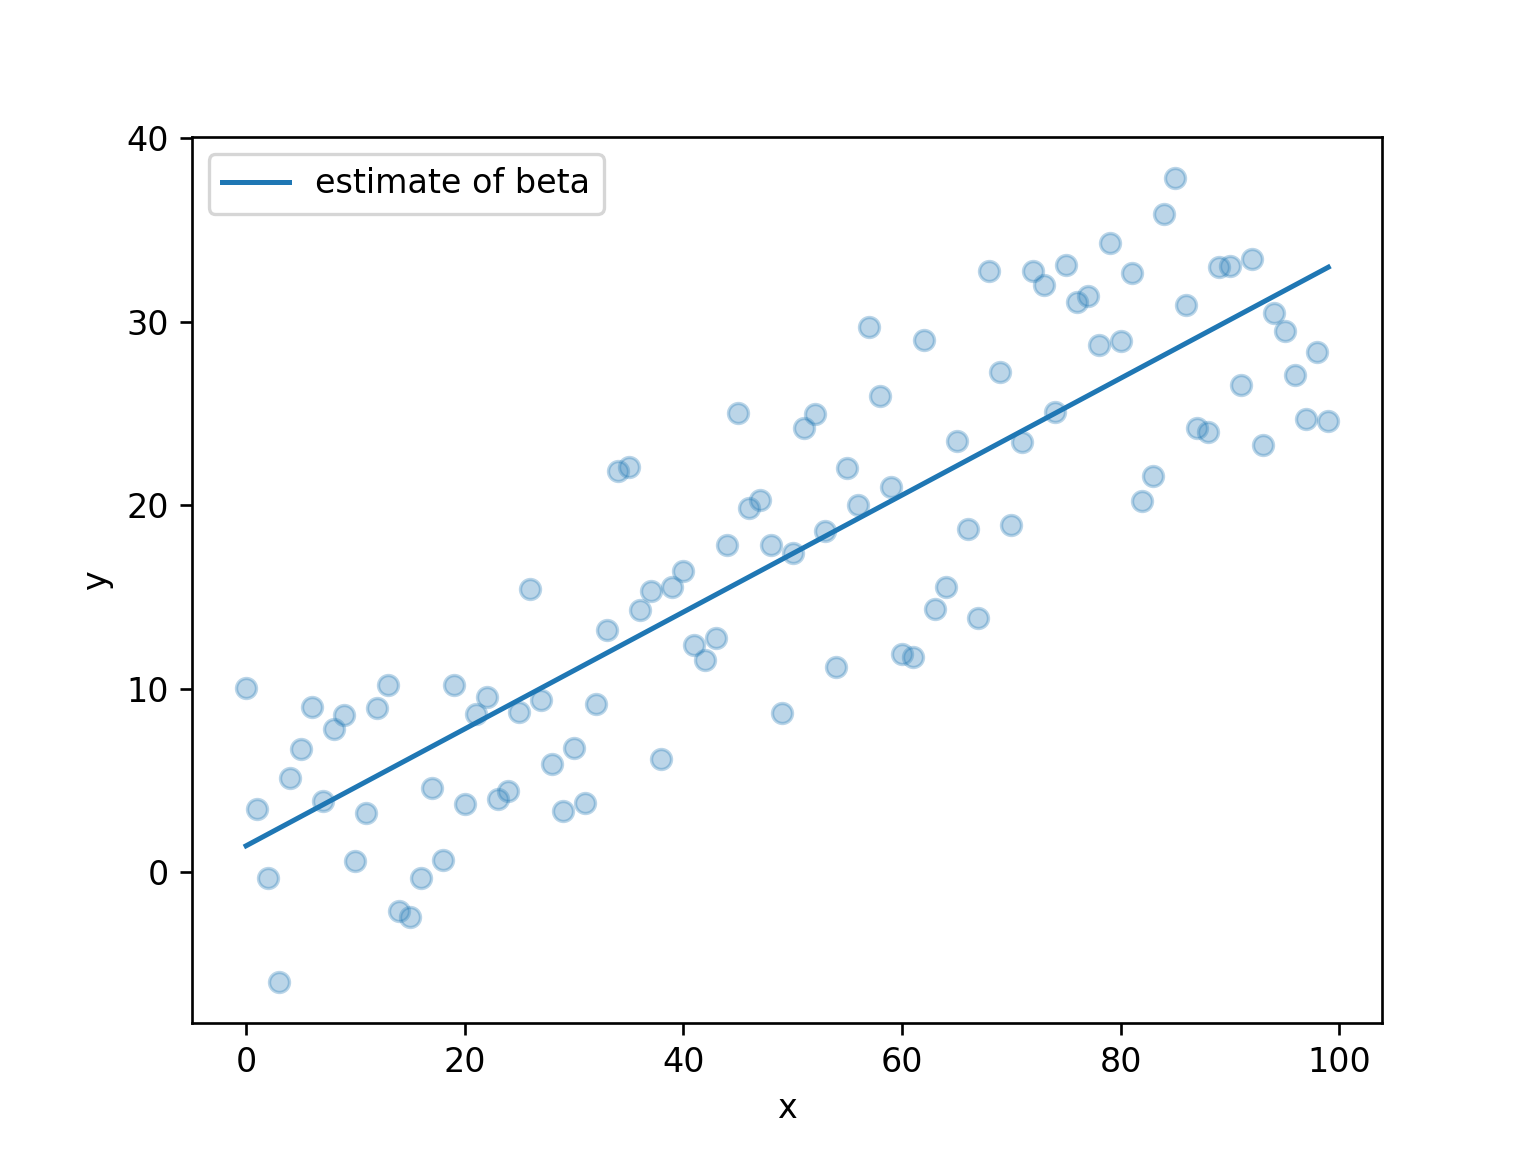

In [3]:
n = 100
X = np.arange(n)
eps = np.random.uniform(-10,10,size=(100,))
y = .3*X + 3 + eps #linear form

beta = ols(X,y) 

plt.plot(X,beta[0]+beta[1]*X,label="estimate of beta") #visualize results
plt.scatter(X,y,alpha=0.3)
plt.ylabel('y')
plt.xlabel('x')
plt.legend()
plt.show()

## Problem 3
Write a function that finds the least squares estimator for rank-deficient models using the SVD. 
The function should still take $X$ and **y** as inputs. Call the function **svd_ols** and return the least squares estimator for $\beta$ as a numpy array.

In [4]:
def svd_ols(X, y):
    """
    Solves for the least squares estimator using the SVD.
    Add a column of 1s to X.
    Parameters:
        X: n x d numpyarray
        y: n x 1 numpyarray
    Returns:
        beta: d x 1 numpy array
    """
    X = np.column_stack((np.ones(X.shape[0]),X)) #add column of ones
    u,s,vh = np.linalg.svd(X,full_matrices=False) #svd method
    s = np.ones(len(s)) / s #inverse of the matrix (but not yet a matrix until np.diag)
    return vh.T @ np.diag(s) @ (u.T @ y)

## Problem 4
Use your function **svd_ols** to find the least squares estimator for a cubic polynomial. 
Create a plot that shows a scatter plot of the data and a curve using the least squares estimator. 
Your plot should include a title, axis labels, and a legend.

<IPython.core.display.Javascript object>


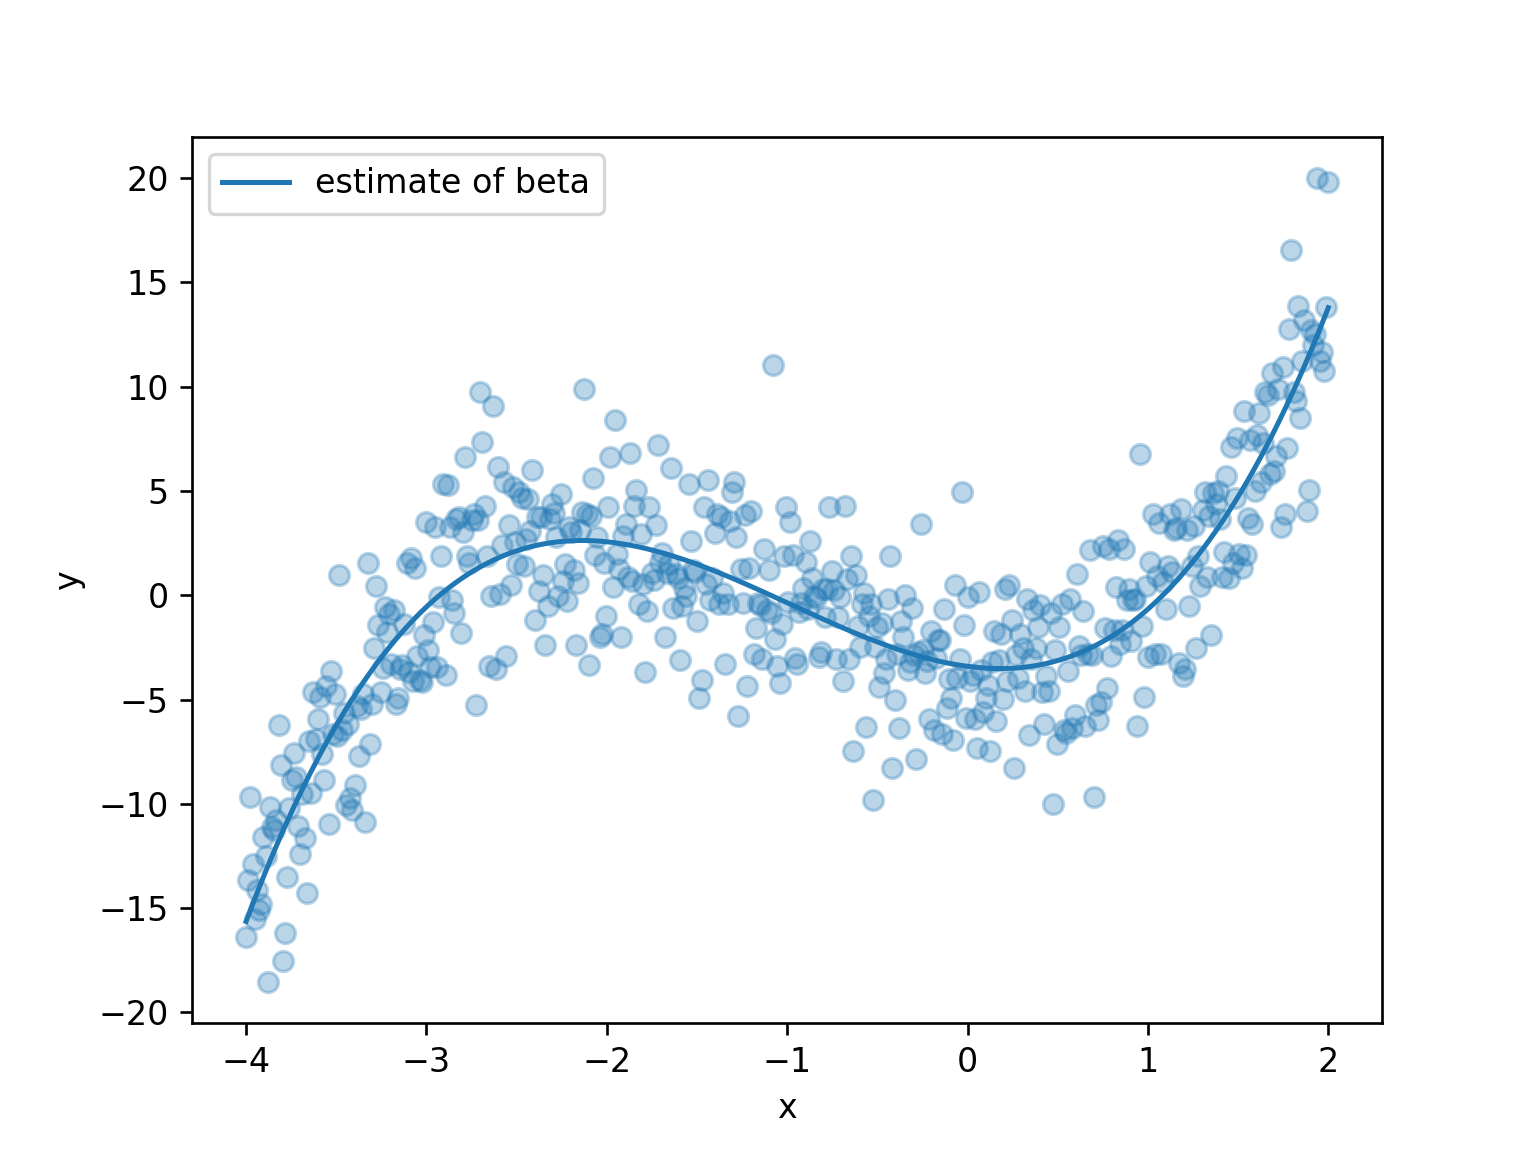

In [5]:
x = np.linspace(-4, 2, 500)
y = x**3 + 3*x**2 - x - 3.5
eps = np.random.normal(0, 3, len(y)) # Create noise
y += eps # Add noise to randomize data

X = np.column_stack((x,x**2,x**3)) #build the data matrix

beta = svd_ols(X,y)

plt.plot(x,np.column_stack((np.ones(X.shape[0]),X)) @ beta,label="estimate of beta") #just do a dot product to visualize this
plt.scatter(x,y,alpha=0.3)
plt.ylabel('y')
plt.xlabel('x')
plt.legend()
plt.show()

## Problem 5
The file **realestate.csv** contains transaction data from 2012-2013. 
It has columns for transaction data, house age, distance to nearest MRT station, number of convenience stores, latitude, longitude, and house price of unit area.
Each row in the array is a separate measurement.

Find the combination of variables that builds the model with the best $R^2$ value when predicting **house price of unit area**. Use statsmodels to build each model and calculate $R^2$. Use **statsmodels** to build each model and calculate $R^2$. Using the same combination of variables, time the methods **ols**, **svd_ols**, and **statsmodels** . Return a list with the first element being a tuple of times for each method and the second element being the best $R^2$ value from the first part of the problem.

In [6]:
def problem5():
    """
    Find the best R2 value using statsmodels.
    Then time ols, svd_ols, and statsmodlels.
    Returns:
        list(): a tuple of times and the best R2 value
    """
    data = pd.read_csv("realestate.csv")
    regressors = data.columns[1:-1].tolist()
    reg_combos = [list(combinations(regressors,r)) for r in range(1,len(regressors)+1)]
    reg_combos = [list(combo) for combo in list(chain.from_iterable(reg_combos))] #unpack list
    r_squared = [] #gather r_squared for each model
    y = data['Y house price of unit area'].values
    
    ols_times = []
    svd_ols_times  = [] #times for each method
    sm_times = []
    
    for reg_combo in reg_combos:
        X = data[reg_combo].values
        
        a = time.time() #time the method
        ols(X,y)
        ols_times.append(time.time()-a)
        
        b = time.time()
        svd_ols(X,y)
        svd_ols_times.append(time.time()-b)
        
        X = sm.add_constant(X)
        c = time.time()
        model = sm.OLS(y,X).fit()
        sm_times.append(time.time()-c)
        
        r_squared.append(model.rsquared)
        
        
    maxdex = np.argmax(r_squared)
    times = (ols_times[maxdex],svd_ols_times[maxdex],sm_times[maxdex])
    
    
    return [times,np.max(r_squared)]

In [7]:
problem5()

[(0.0007746219635009766, 0.00035572052001953125, 0.0010373592376708984),
 0.5823704472723106]

## Problem 6
Use the file **realestate.csv** and the Python Example on page 4 as a template for constructing **y** and $X$ and calculating model AIC and BIC. 
For the dependent variable, use **house price of unit area**. 
For the independent variables, use **distance to the nearest MRT station**, **number of convenience stores**, **latitude**, and **longitude**.

Find the model that has the lowest AIC and the model that has the lowest BIC. Are they the same model? Print the features of the model with the lowest AIC as a list.

In [8]:
data = pd.read_csv("realestate.csv")
regressors = data.columns[3:-1].tolist()
reg_combos = [list(combinations(regressors,r)) for r in range(1,len(regressors)+1)]
reg_combos = [list(combo) for combo in list(chain.from_iterable(reg_combos))] #unpack the lists
aic = [] #akaike and bayesian information criterion for each model
bic = []
y = data['Y house price of unit area'].values

for reg_combo in reg_combos: #iterate over models
    X = data[reg_combo].values

    X = sm.add_constant(X)
    model = sm.OLS(y,X).fit()

    aic.append(model.aic)
    bic.append(model.bic)

minner_aic, minner_bic = np.argmin(aic), np.argmin(bic) #find mindex of aic, bic

assert reg_combos[minner_aic] == reg_combos[minner_bic] #if they're the same, then we print

print(f"They are the same model.\nFeatures for AIC are: {reg_combos[minner_aic]}")
print(f"Features for BIC are: {reg_combos[minner_bic]}")

print(f"AIC:{aic[minner_aic]}")
print(f"BIC:{bic[minner_bic]}")

They are the same model.
Features for AIC are: ['X3 distance to the nearest MRT station', 'X4 number of convenience stores', 'X5 latitude']
Features for BIC are: ['X3 distance to the nearest MRT station', 'X4 number of convenience stores', 'X5 latitude']
AIC:3038.5362593218306
BIC:3054.6397232171316


## Problem 7
Use Ridge and Lasso Regression to model **house price of unit area** from the file **realestate.csv**.
Before fitting each model, run a GridSearch on $\alpha$ to find the optimal value.
Then use the optimal $\alpha$ to fit the model.
Once you have fit the model, you can use the **score** method to get $R^2$. 
Print $R^2$ for each model as a tuple. 
How do these models compare to the models in problem 6?

In [9]:
data = pd.read_csv("realestate.csv") #prepare the data
regressors = data.columns[1:-1].tolist()
y = data['Y house price of unit area'].values
X = data[regressors].values

#Ridge
ridge_model = linear_model.RidgeCV(alphas=np.logspace(-6,6,13)) #cross validation
ridge_model.fit(X,y) #then fit
ridge_R2 = ridge_model.score(X,y)

#Lasso
lasso_model = linear_model.LassoCV(alphas=np.logspace(-6,6,13)) #cross validation
lasso_model.fit(X,y) #then fit
lasso_R2 = lasso_model.score(X,y)

print(ridge_R2,lasso_R2)

0.5823546082714722 0.5822617746793024


My grand comparison: Essentially the same R^2 values as in problem 5.